In [27]:
## Run pip install -r requirements.txt
%pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [29]:
import pandas as pd
# Load the Excel file
complaints_df = pd.read_excel('./PI_Complaints.xlsx')

# Display the first few rows of the data
complaints_df.head()

,Notification Number,er key for sap and saptw notifications,Notification Date,Material Number,Material Description,Brand,Business,Code Description,SAP Damage Code Text,Short Text,...,BreakDown Duration,Build Date,Ship To Customer,Ship To Party,Sold To Customer,Sold To Party,OOB Failure,Material Quantity,subject_long_text sor sap and srctw,Quantity
0,100022,319015549.0,2024-09-05 06:24:00,1153533,Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798,AC611,PATIENT INTERFACE,AC611 _ LEAK,LEAK,Product malfunction / General Catalog Profile ...,...,NaN,NaN,NaN,NaN,30302881.0,"Yagami Co.,Ltd.",No,1.0,NaN,1.0
1,101106,319017578.0,2024-09-05 18:14:00,1104925,L PICO NASAL MASK W/ HGR JPN,PICO,PATIENT INTERFACE,PICO _ PHYS,PHYSICAL DAMAGE,Operation manual failure / PICO MASK /Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,3.0,* 09/05/2024 10:39:50 EST (NMARRONE)\n* Per Er...,3.0
2,101129,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,"DAMAGE,PHYSICAL",Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
3,101249,319018673.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ CONT,CONTAMINATION OBSERVED,foreign substance (hair)/TRILOGY/JAPAN,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:34:15 EST (NMARRONE)\n* Per Er...,1.0
4,101258,319018807.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ COSM,COSMETIC DAMAGE,product scratch/ General Catalog Profile/ Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:36:49 EST (NMARRONE)\n* Per Er...,1.0


## Data Cleaning: Filter out the columns that aren't important

In [41]:
# Display cleaned DataFrame
complaints_cleaned_df.head()

,er key for sap and saptw notifications,Notification Date,Material Number,Material Description,Brand,Business,Code Description,SAP Damage Code Text,Short Text,Country,...,BreakDown Duration,Build Date,Ship To Customer,Ship To Party,Sold To Customer,Sold To Party,OOB Failure,Material Quantity,subject_long_text sor sap and srctw,Quantity
0,319015549.0,2024-09-05 06:24:00,1153533,Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798,AC611,PATIENT INTERFACE,AC611 _ LEAK,LEAK,Product malfunction / General Catalog Profile ...,Japan,...,NaN,NaN,NaN,NaN,30302881.0,"Yagami Co.,Ltd.",No,1.0,NaN,1.0
1,319017578.0,2024-09-05 18:14:00,1104925,L PICO NASAL MASK W/ HGR JPN,PICO,PATIENT INTERFACE,PICO _ PHYS,PHYSICAL DAMAGE,Operation manual failure / PICO MASK /Japan,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,3.0,* 09/05/2024 10:39:50 EST (NMARRONE)\n* Per Er...,3.0
2,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,"DAMAGE,PHYSICAL",Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
3,319018673.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ CONT,CONTAMINATION OBSERVED,foreign substance (hair)/TRILOGY/JAPAN,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:34:15 EST (NMARRONE)\n* Per Er...,1.0
4,319018807.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ COSM,COSMETIC DAMAGE,product scratch/ General Catalog Profile/ Japan,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:36:49 EST (NMARRONE)\n* Per Er...,1.0


In [39]:
print(complaints_df.head())

  Notification Number  er key for sap and saptw notifications  \
0              100022                             319015549.0   
1              101106                             319017578.0   
2              101129                             319017661.0   
3              101249                             319018673.0   
4              101258                             319018807.0   

    Notification Date Material Number  \
0 2024-09-05 06:24:00         1153533   
1 2024-09-05 18:14:00         1104925   
2 2024-09-05 18:14:00         1128652   
3 2024-09-05 18:19:00          312149   
4 2024-09-05 18:19:00          312149   

                       Material Description           Brand  \
0        Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798           AC611   
1              L PICO NASAL MASK W/ HGR JPN            PICO   
2  S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK           AF541   
3                Disp Exhalation Port Pk/10  PI ACCESSORIES   
4                Disp Exhalation Port Pk/10  PI

In [32]:

# complaints_df = complaints_df[[]]

# needed columns:
  # Country
  # possibly Sold to Party: maybe a trend among party complaints
  # Short Text: short description of complaint/issue
  # SAP Damage Code Text: the type of damage
  # possibly Brand: could be a trend among brands being an issue
  # Notification Date: possible trend among times with complaints
  # OOB Failure

# complaints_cleaned_df
complaints_cleaned_df = complaints_df[['Notification Date', 'Country', 'Short Text', 'SAP Damage Code Text']]


# country - short text
  # sentiments_df
  # sentiment analysis
  # ex. overall positive/negative
sentiments_df = complaints_df[['Country', 'Short Text']]

# country - notification date
notifications_df = complaints_df[['Country', 'Notification Date']]

print(f"Sentiments:\n {sentiments_df}")
print(f"Notification Dates:\n {notifications_df}")

Sentiments:
              Country                                         Short Text
0              Japan  Product malfunction / General Catalog Profile ...
1              Japan        Operation manual failure / PICO MASK /Japan
2              Japan     Sizing gauge is broken/AF541 Oro-Nasal Mask/JP
3              Japan             foreign substance (hair)/TRILOGY/JAPAN
4              Japan    product scratch/ General Catalog Profile/ Japan
...              ...                                                ...
21671          Japan                     Parts shortage/Dreamwear/Japan
21672  United States  Received without a pillow and cushion/DreamWea...
21673  United States  Received without a pillow and cushion/DreamWea...
21674            NaN                                                NaN
21675            NaN                                                NaN

[21676 rows x 2 columns]
Notification Dates:
              Country   Notification Date
0              Japan 2024-09-05 06:

## Modeling with ML

### Notifications Analysis

In [33]:
notifications_df.head()

,Country,Notification Date
0,Japan,2024-09-05 06:24:00
1,Japan,2024-09-05 18:14:00
2,Japan,2024-09-05 18:14:00
3,Japan,2024-09-05 18:19:00
4,Japan,2024-09-05 18:19:00


In [36]:

notifications_df_cleaned = notifications_df.dropna(subset=['Country', 'Notification Date'])
notifications_df_cleaned.set_index('Notification Date', inplace=True)
complaints_by_country = notifications_df_cleaned.groupby('Country').resample('M').size().reset_index(name='Complaint Count')


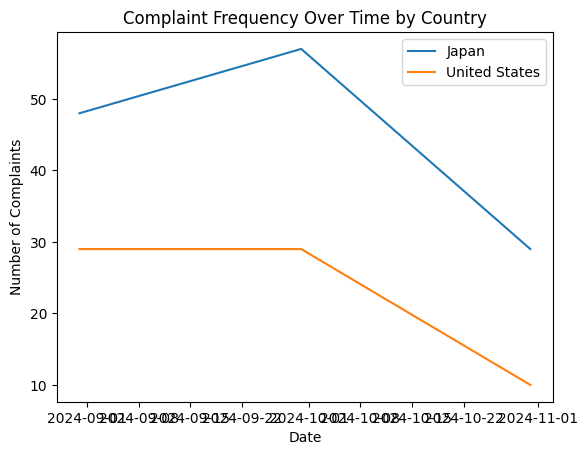

In [37]:
import matplotlib.pyplot as plt

for country in ['Japan', 'United States']:
    country_data = complaints_by_country[complaints_by_country['Country'] == country]
    plt.plot(country_data['Notification Date'], country_data['Complaint Count'], label=country)

plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Complaint Frequency Over Time by Country')
plt.legend()
plt.show()
